# Assignment 1: Grid World Environment

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import random
import time
from pprint import pprint
from itertools import count
from gym import spaces
from collections import OrderedDict, deque
from tqdm import tqdm
from operator import add
from torch.distributions import Categorical
import torch.nn.functional as F
# torch.autograd.set_detect_anomaly(True)
%matplotlib inline

Below class defines the grid environment

In [2]:
class GridEnvironment(gym.Env):
    
    def __init__(self, is_stochastic=False):
        '''
        Initialize parameters of the environment.
        '''
        self.action_space = 4
        self.observation_space = spaces.Discrete(25)
        self.action_value = spaces.Discrete(4)
        self.max_timesteps = 40 # Maximum timesteps that the agent can take
        self.step_reward = -1
        self.is_stochastic = is_stochastic
    
    def reset(self):
        '''
        Resets the environment and resets the dictionary that checks
        if the pizza, danger and berrys states were visited or not
        
        Returns:
        observation: State of the environment
        '''
        self.timestep = 0
        self.done = False
        self.agent_pos = np.array([0, 0]) # Starting position
        self.monster_pos = [1, 2]
        self.pit_pos = [3, 1]
        self.pizza_pos = [3, 0]
        self.danger_pos = [0, 3]
        self.berry_pos = [2, 2]
        self.goal_pos = [4, 4]
        
        # Dictionary to check if the state was visited or not
        # If the state is visited then the image should not be
        # shown and the reward should not be received
        self.is_visited = {
            'pizza_pos': [False, False],
            'danger_pos': [False, False],
            'berry_pos': [False, False]
        }
        
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.6
        observation = self.state.flatten()        
        return observation

    def step(self, action):
        '''
        Step function takes action as the parameters and performs the action
        based on the environment i.e. whether it is deterministic or 
        stochastic.
        
        Parameters:
        action: Action given by the agent
        
        Returns:
        observation: State of the environment
        reward: Reward received by the agent
        done: Boolean value. If the agent reached the goal or was dead
        info: Current position of the agent
        '''
        
        # print('Action given by the agent: {} ({})'.format(action, self.action_map(action)))

        # If the environment is stochastic then
        # randomly choose the actions based on the probability distribution
        if self.is_stochastic:
            if action == 0:
                action = np.random.choice(4, 1, p=[0.94, 0.02, 0.02, 0.02])[0]
            elif action == 1:
                action = np.random.choice(4, 1, p=[0.02, 0.94, 0.02, 0.02])[0]
            elif action == 2:
                action = np.random.choice(4, 1, p=[0.02, 0.02, 0.94, 0.02])[0]
            elif action == 3:
                action = np.random.choice(4, 1, p=[0.02, 0.02, 0.02, 0.94])[0]
        
        # print('Action performed by the environment: {} ({})'.format(action, self.action_map(action)))
        
        # Change the agent position based on the action
        if action == 0:
            self.agent_pos[1] -= 1 # Down
        elif action == 1:
            self.agent_pos[1] += 1 # Up
        elif action == 2:
            self.agent_pos[0] += 1 # Right
        elif action == 3:
            self.agent_pos[0] -= 1 # Left
            
        # Clips the agent position if agent goes outside the gird
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.6

        observation = self.state.flatten()
        
        # Defines rewards received based on the state the agent reached
        reward = 0
        if (self.agent_pos == self.danger_pos).all() and (not self.is_visited['danger_pos'][0]):
            reward = -3
            self.is_visited['danger_pos'][0] = True
        elif (self.agent_pos == self.monster_pos).all():
            reward = -50
        elif (self.agent_pos == self.berry_pos).all() and (not self.is_visited['berry_pos'][0]):
            reward = 10
            self.is_visited['berry_pos'][0] = True
        elif (self.agent_pos == self.pizza_pos).all() and (not self.is_visited['pizza_pos'][0]):
            reward = 5
            self.is_visited['pizza_pos'][0] = True
        elif (self.agent_pos == self.pit_pos).all():
            reward = -50
        elif (self.agent_pos == self.goal_pos).all():
            reward = 50
        else:
            reward = self.step_reward
        
        self.timestep += 1
        
        # Change the boolean flag 'done' to True if the agent reaches the goal or the monster or the pit or
        # maximum timesteps have been reached
        if (self.timestep >= self.max_timesteps) or (self.agent_pos == self.monster_pos).all() or (self.agent_pos == self.pit_pos).all() or (self.agent_pos == self.goal_pos).all():
            done = True
        else:
            done = False
        
        # info parameter holds the current position of the agent
        info = {'current_agent_pos': self.agent_pos}
        
        return observation, reward, done, info
    
    def render(self):
        '''
        Renders the state of the environment
        '''
        
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)
        
        # If the agent has visited any of the states where he receives a positive or a negative reward then
        # don't show the image of the items other than the agent
        if (self.agent_pos != self.monster_pos).any() and (self.agent_pos != self.pit_pos).any() and ((self.agent_pos != self.danger_pos).any() or self.is_visited['danger_pos'][1]) and ((self.agent_pos != self.berry_pos).any() or self.is_visited['berry_pos'][1]) and ((self.agent_pos != self.pizza_pos).any() or self.is_visited['pizza_pos'][1]) and (self.agent_pos != self.goal_pos).any():
            agent = AnnotationBbox(OffsetImage(plt.imread('./images/agent.png'), zoom=0.4),  # Plotting the agent.
                     list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent)
        
        # Monster
        if (self.agent_pos == self.monster_pos).all():
            agent_monster = AnnotationBbox(OffsetImage(plt.imread('./images/agent_monster.png'), zoom=0.25),  # Plotting the agent.
                       list(map(add, self.monster_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent_monster)
        else:
            monster = AnnotationBbox(OffsetImage(plt.imread('./images/monster.png'), zoom=0.15),  # Plotting the agent.
                       list(map(add, self.monster_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(monster)

        # Agent fell in the pit
        if (self.agent_pos == self.pit_pos).all():
            agent_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_fell.png'), zoom=0.24),  # Plotting the agent.
                       list(map(add, self.pit_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent_pit)
        else:
            pit = AnnotationBbox(OffsetImage(plt.imread('./images/pit.png'), zoom=0.15),  # Plotting the agent.
                               list(map(add, self.pit_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(pit)

        # Pizza
        if (not self.is_visited['pizza_pos'][1]):
            if (self.agent_pos == self.pizza_pos).all():
                agent_pizza = AnnotationBbox(OffsetImage(plt.imread('./images/agent_pizza.png'), zoom=0.37),  # Plotting the agent.
                                   list(map(add, self.pizza_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_pizza)
                self.is_visited['pizza_pos'][1] = True
            else:
                pizza = AnnotationBbox(OffsetImage(plt.imread('./images/pizza.png'), zoom=0.1),  # Plotting the agent.
                                       list(map(add, self.pizza_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(pizza)

        # Danger
        if (not self.is_visited['danger_pos'][1]):
            if (self.agent_pos == self.danger_pos).all():
                agent_danger = AnnotationBbox(OffsetImage(plt.imread('./images/agent_danger.png'), zoom=0.35),  # Plotting the agent.
                                   list(map(add, self.danger_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_danger)
                self.is_visited['danger_pos'][1] = True
            else:
                danger = AnnotationBbox(OffsetImage(plt.imread('./images/danger.png'), zoom=0.25),  # Plotting the agent.
                                       list(map(add, self.danger_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(danger)

        # Agent Won
        if (self.agent_pos == self.goal_pos).all():
            agent_won = AnnotationBbox(OffsetImage(plt.imread('./images/agent_won.png'), zoom=0.07),  # Plotting the agent.
                               list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(agent_won)
        else:
            trophy = AnnotationBbox(OffsetImage(plt.imread('./images/trophy.png'), zoom=0.15),  # Plotting the agent.
                                   list(map(add, self.goal_pos, [0.41, 0.5])), frameon=False)
            ax.add_artist(trophy)

        # Berry
        if (not self.is_visited['berry_pos'][1]):
            if (self.agent_pos == self.berry_pos).all():
                agent_berry = AnnotationBbox(OffsetImage(plt.imread('./images/agent_berry.png'), zoom=0.45),  # Plotting the agent.
                                   list(map(add, self.berry_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_berry)
                self.is_visited['berry_pos'][1] = True
            else:
                berry = AnnotationBbox(OffsetImage(plt.imread('./images/berry.png'), zoom=0.5),  # Plotting the agent.
                                       list(map(add, self.berry_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(berry)

        plt.xticks([0, 1, 2, 3, 4, 5])
        plt.yticks([0, 1, 2, 3, 4, 5])
        plt.grid()
        plt.show()
    
    def action_map(self, action):
        '''
        Action dictionary. Maps values to the action
        '''
        action_dict = {
            0: 'Down',
            1: 'Up',
            2: 'Right',
            3: 'Left'
        }
        return action_dict[action]

In [77]:
class DuelingDQN(nn.Module):    
    def __init__(self,state,lr):
        super(DuelingDQN, self).__init__()

        self.fc1 = nn.Linear(state, 32)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(32, 64)
        self.fc_adv = nn.Linear(32, 64)

        self.value = nn.Linear(64, 1)
        self.adv = nn.Linear(64, 4)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)


    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advantageAverage = torch.mean(adv)
        Q = value + adv - advantageAverage

        return Q


In [78]:
class DQNagent:
    '''
    DQNagent is a class that defines the agent.
    '''
    def __init__(self, state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.001
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = 'cpu'
        
        self.policy_net = DuelingDQN(self.state_size, self.learning_rate).to(self.device)
        self.target_net = DuelingDQN(self.state_size, self.learning_rate).to(self.device)
        self.update_target_policy()
        
    def get_action(self, current_state_vector):
        '''
        This function defines epsilon greedy behavior of the agent.
        '''
        rand_num = np.random.random()
        if rand_num < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if not torch.is_tensor(current_state_vector):
                current_state_vector = torch.from_numpy(current_state_vector).float().to(self.device)
            
            with torch.no_grad():
                q_values = self.policy_net.forward(current_state_vector).view(-1,)
            best_action = torch.argmax(q_values).item()
        return best_action
    
    def append_memory(self, state, action, reward, next_state, done):
        '''
        Save each experience in the replay memory
        '''
        self.memory.append((state, action, reward, next_state, done))
    
    def update_target_policy(self):
        '''
        Update the target network parameters based on the policy network parameters
        '''
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def update_epsilon(self):
        '''
        Perform epsilon decay
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    def train_model(self):
        '''
        Train the agent
        '''
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = list()
            actions = list()
            rewards = list()
            next_states = list()
            dones = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                current_state.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done_boolean)
            
            # Convert each list to torch tensors
            current_state = torch.from_numpy(np.array(current_state)).float().to(self.device)
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)

            # Make a forward pass in the policy network based on the current state
            # and choose the q-value of the action
            policy_q_values = self.policy_net.forward(current_state).gather(1, actions.long().view(-1,1)).view(-1,)

            # Make a forward pass in the target network based on the next state
            # and choose the q-value of the action which gives the highest q-value
            policy_best_actions = self.policy_net.forward(next_states).argmax(dim=1).view(-1,1)
            target_q_values = self.target_net.forward(next_states).gather(1, policy_best_actions).view(-1,)
            
            # Compute the target
            y_target = list()
            for index, value in enumerate(target_q_values):
                if dones[index]:
                    y_target.append(rewards[index])
                else:
                    y_target.append(rewards[index] + self.discount_factor * value)
            
            y_target = torch.stack(y_target, dim=0) # Create the list to torch tensor

            # Calculate the MSE loss and perform a backward pass in the policy network
            criterion = nn.MSELoss()
            loss = criterion(y_target, policy_q_values)
            self.policy_net.optimizer.zero_grad()
            loss.backward()

            self.policy_net.optimizer.step()
    
    def test_model(self, env, episodes, perform_render=False):
        '''
        Test the agent behavior after it has been trained
        Agent follows only the greedy policy
        '''
        
        # print('\nTesting the agent after it has been trained')
        # print('Agent chooses only greedy actions from the learnt policy')
        
        total_reward_arr = list()
        timesteps = 0
        self.epsilon = 0
        
        for episode in range(episodes):
            current_state = env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_action(current_state)
                next_state, reward, done, info = env.step(action)

                total_reward += reward
                current_state = next_state.copy()
                
                # Render only for the final episode
                if perform_render and episodes-1 == episode:
                    env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr
    
    def save_model(self, filename):
        '''
        Save the trained model
        '''
        torch.save(self.policy_net.state_dict(), filename)
    
    def load_model(self, filename):
        '''
        Load the model
        '''
        self.policy_net.load_state_dict(torch.load(filename))

In [79]:

def plot_graphs(title, total_reward, epsilon_decay, cumulative_reward, avg_timestep, episodes):
    '''
    This functions plots the graphs for rewards, epsilon, success, failure and avergae timesteps
    
    Success is defined when the agent has reached the goal state
    Failure is defined when the agent meets the monster or falls in the pit
    '''
    # fig, axs = plt.subplots(3,2, figsize=(12,17))
    fig, axs = plt.subplots(2,2, figsize=(12,13))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.91, hspace=0.2, wspace=0.2)
    axs[0,0].plot(epsilon_decay_arr)
    axs[0,0].set_title('Epsilon Decay')
    axs[0,0].set_xlabel('Episodes')
    axs[0,0].set_ylabel('Epsilon')
    
    axs[0,1].plot(avg_timestep_arr)
    axs[0,1].set_title('Average timesteps per 50 episodes')
    axs[0,1].set_xticks(np.arange(len(avg_timestep)))
    axs[0,1].set_xticklabels(list(range(0,episodes+1,50))[1:], rotation=90)
    axs[0,1].set_xlabel('Episodes')
    axs[0,1].set_ylabel('Timesteps')
    
    axs[1,0].plot(total_reward_arr)
    axs[1,0].set_title('Total Reward per episode')
    axs[1,0].set_xlabel('Episodes')
    axs[1,0].set_ylabel('Rewards')
    
    axs[1,1].plot(cumulative_reward_arr)
    axs[1,1].set_title('Cumulative reward over all episodes')
    axs[1,1].set_xlabel('Episodes')
    axs[1,1].set_ylabel('Cumulative Rewards')
    
    plt.show()

### Part 1: Defining RL environment

#### Main function

In [80]:
# Main function where we loop through each episode
# and make the agent explore and then exploit the environment
# to learn the optimal policy

def main(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len, update_frequency, episodes, test_episodes, perform_render):
    device = 'cpu'
    total_reward_arr = list() # Store total reward per episode values
    cumulative_reward_arr = list() # Store cumulative reward
    epsilon_decay_arr = [epsilon] # Store each epsilon value after decay
    timestep_arr = list() # Store the timestep per episode
    avg_timestep_arr = list() # Store average timestep every 20 episodes
    test_total_reward_arr = list()

    agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
    success_count = 0
    failure_count = 0
    train_timestep = 10

    for episode in tqdm(range(episodes)):
        done = False
        total_reward = 0
        timesteps = 0
        env = GridEnvironment()
        current_state = env.reset().copy()

        while not done:
            action = agent.get_action(current_state)
            next_state, reward, done, info = env.step(action)

            agent.append_memory(current_state, action, reward, next_state, done)

            if timesteps % train_timestep == 0:
                agent.train_model()

            current_state = next_state.copy()
            total_reward += reward
            timesteps += 1

        if episode % update_frequency == 0:
            agent.update_target_policy()

        epsilon = agent.update_epsilon()
        epsilon_decay_arr.append(epsilon)

        timestep_arr.append(timesteps)

        # Calculate average timesteps for 50 timesteps
        if done and (episode+1) % 50 == 0:
            avg_timestep_arr.append(np.average(timestep_arr))
            timestep_arr.clear()

        total_reward_arr.append(total_reward)
      
        if len(cumulative_reward_arr) == 0:
            cumulative_reward = total_reward
        else:
            cumulative_reward = cumulative_reward_arr[-1] + total_reward
        cumulative_reward_arr.append(cumulative_reward)
    
    # Test the agent
    test_total_reward_arr = agent.test_model(env, test_episodes, perform_render=perform_render)

    # Save the model weights
    agent.save_model("Dueling_DQN_gridworld_weights.pth")
    
    return total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, test_total_reward_arr

In [111]:
# Parameters
env = GridEnvironment()
state_size = 25
action_size = 4
epsilon = 1.0
epsilon_decay = 0.007
batch_size = 16
lr = 0.001
discount_factor = 0.99
update_frequency = 3
memory_len = 500
episodes = 1000
test_episodes = 100
perform_render = True

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.90it/s]


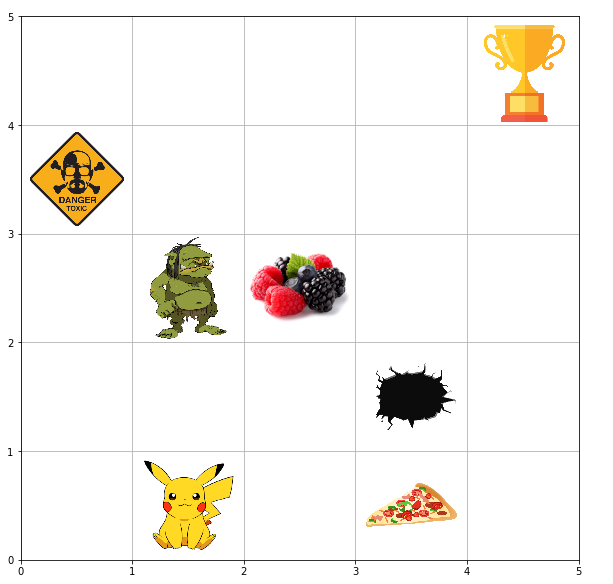

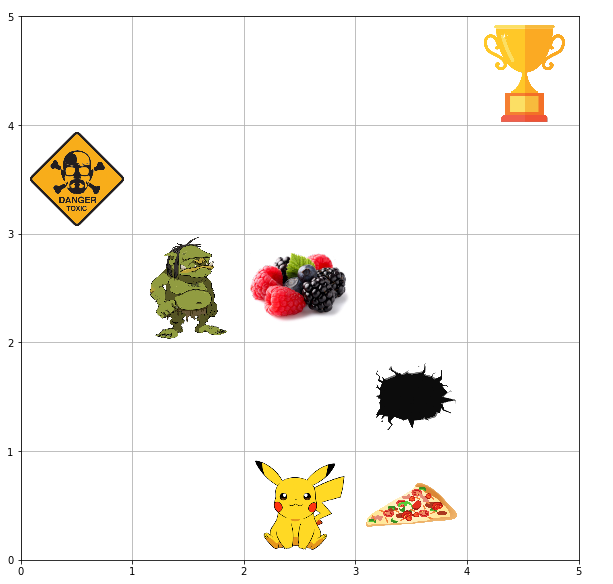

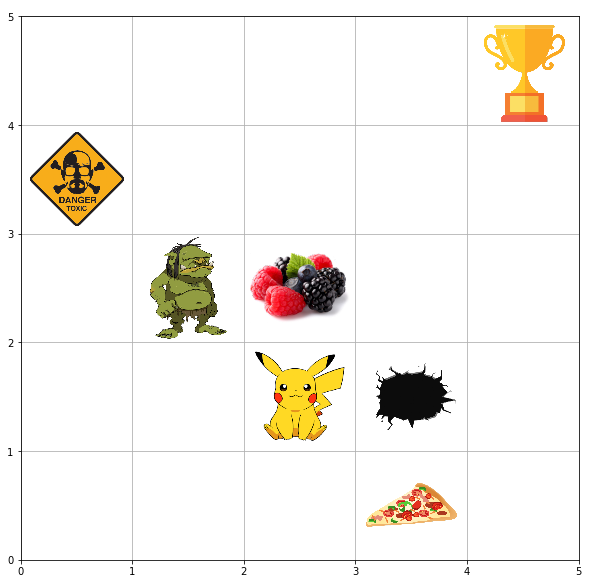

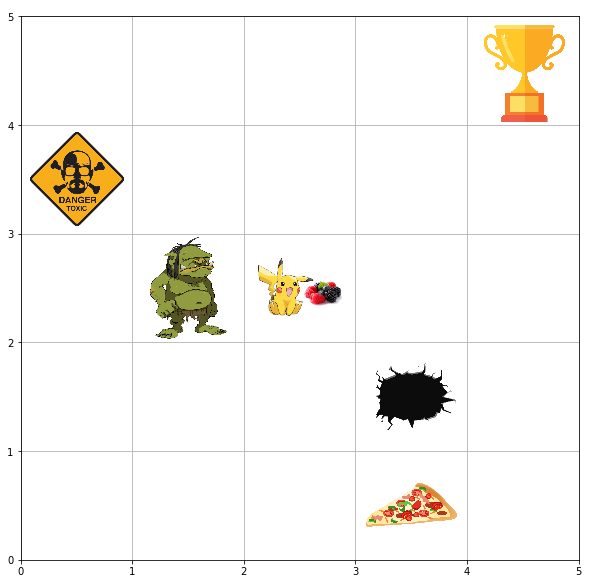

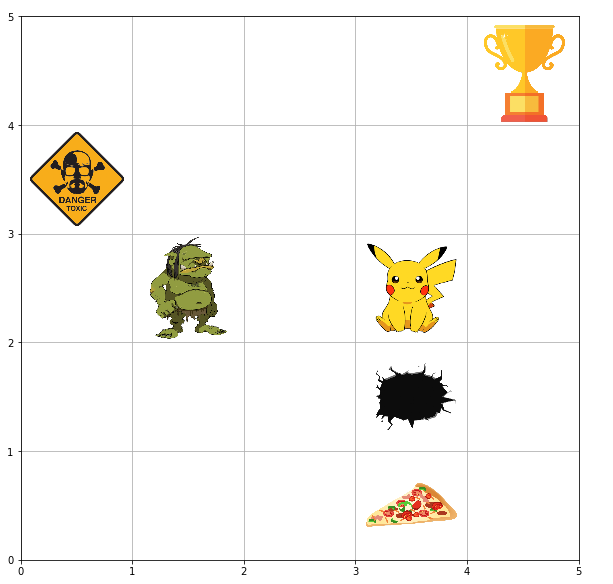

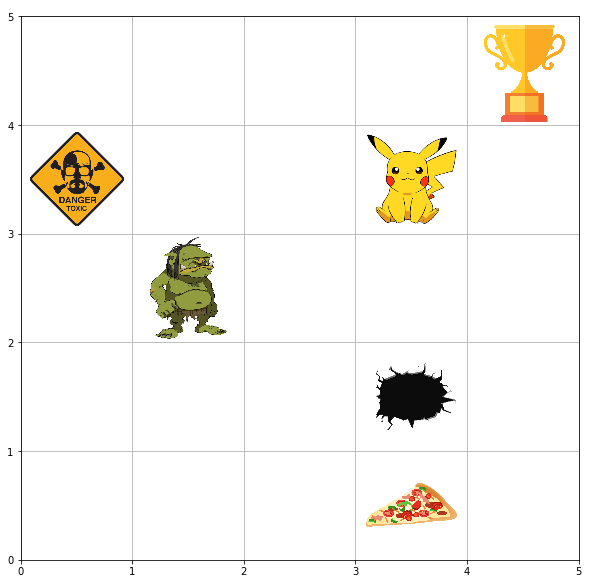

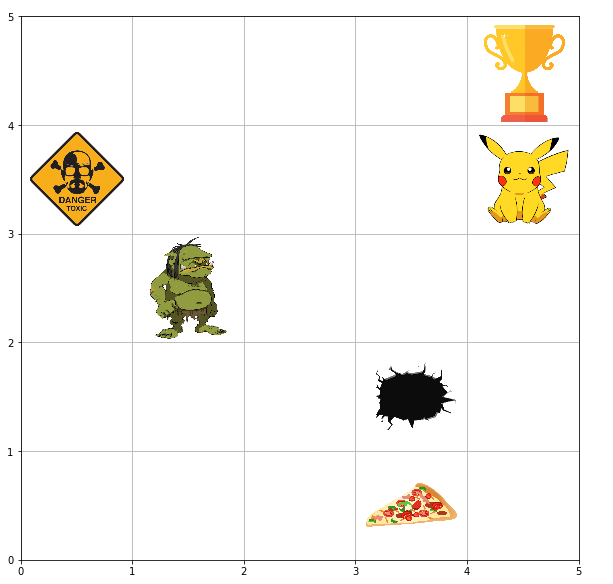

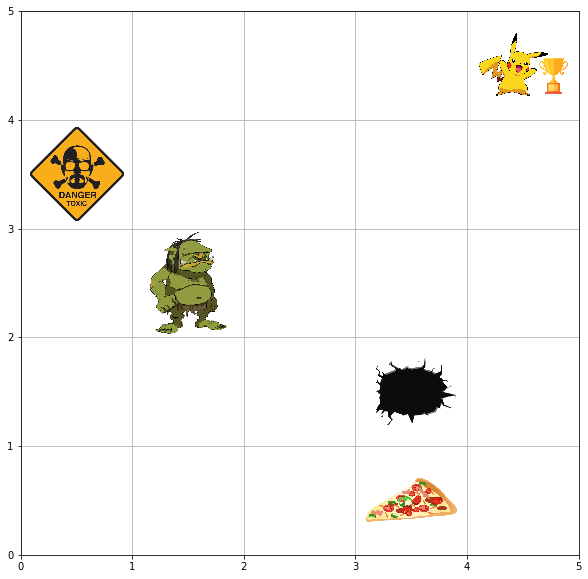

In [112]:
total_reward_arr, epsilon_decay_arr,cumulative_reward_arr, avg_timestep_arr, test_total_reward_arr = main(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len, update_frequency, episodes, test_episodes, perform_render)

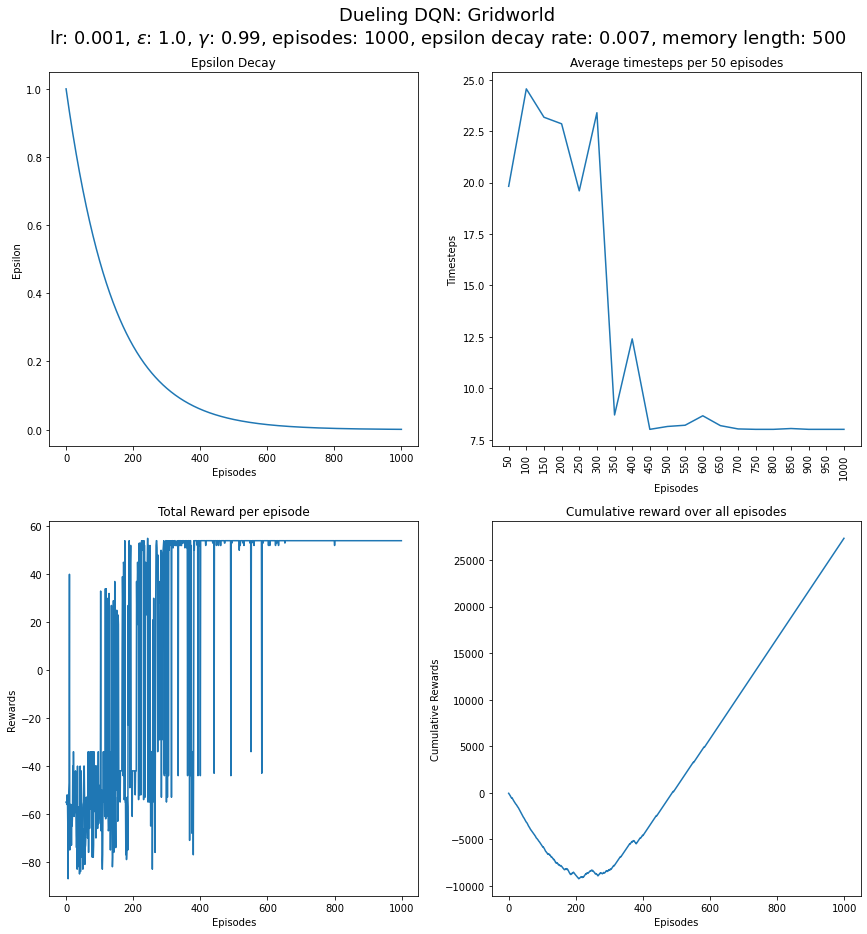

In [113]:
title = 'Dueling DQN: Gridworld\n' + r'lr: {}, $\epsilon$: {}, $\gamma$: {}, episodes: {}, epsilon decay rate: {}, memory length: {}'.format(lr, epsilon, discount_factor, episodes, epsilon_decay, memory_len)
plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

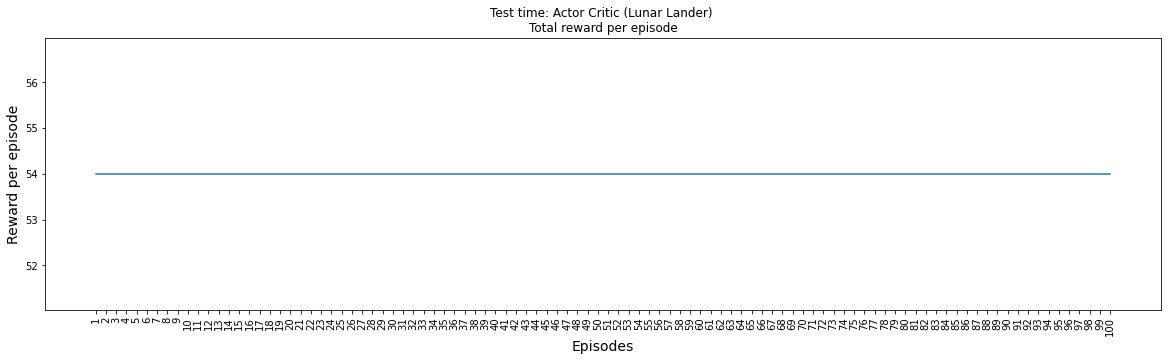

In [114]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr)
plt.title('Test time: Actor Critic (Lunar Lander) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()